In [1]:
import zipfile
import cv2
import os
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs

In [2]:
Pi = 3.14159265358979323846

def knn_graph(Data, method, k):
    # 获取样本点的数量
    n = Data.shape[0]
    # 初始化k近邻图的邻接矩阵
    knn_adjacency_matrix = np.zeros((n, n))  
    # 计算欧式距离矩阵
    distances = np.sqrt(np.sum((Data[:, None] - Data) ** 2, axis=2))
    if method == 'epsilon':
        return knn_adjacency_matrix, distances
    # 获取每个样本点的最近邻索引
    indices = np.argsort(distances, axis=1)[:, 1:k+1]
    # 构建k近邻图的权重矩阵
    # 遍历每个样本点的最近邻索引
    for i in range(n):
        knn_adjacency_matrix[i, indices[i]] = 1
        knn_adjacency_matrix[indices[i], i] = 1
    return knn_adjacency_matrix, distances


# 以每个点到其他所有点的平均值作为每个数据点的平均邻域半径
def compute_avg_radius(Data, distances): 
    n = Data.shape[0] # 数据集的大小
    radius = np.zeros(n) # 存储每个数据点的平均邻域半径
    for i in range(n): # 计算每个数据点的平均邻域半径
        avg_radius = np.mean(distances[i]) # 每个数据点到其他所有点的平均值
        radius[i] = avg_radius # 存储每个数据点的平均邻域半径
    return radius

# 计算k最近邻索引矩阵或epsilon邻接矩阵
def compute_neighborhood_matrix(Data, method, k):
    n = len(Data)
    knn_adjacency_matrix, distances = knn_graph(Data, method, k)
    if method == 'knn':
        return knn_adjacency_matrix, distances
    elif method == 'epsilon':
        adjacency_matrix, neighbors= np.zeros((n, n))
        radius = compute_avg_radius(Data, distances)  # 计算每个数据点的邻域半径
        for i in range(n):  # 对于数据集中的每个样本点 i
            neighbors = np.where(distances[i] <= radius[i])[0]  # 选择半径内的点作为邻居
            if len(neighbors) > n/2:  # 如果邻居数量超过 n/2
                sorted_indices = np.argsort(distances[i, neighbors])  # 根据距离排序邻居点的索引
                selected_neighbors = neighbors[sorted_indices[:int(n/2)]]  # 仅选择最近的 n/2 个点作为邻居
                adjacency_matrix[i, selected_neighbors] = 1 # 更新邻接矩阵
                adjacency_matrix[selected_neighbors, i] = 1 # 邻接矩阵为对称矩阵
            else:
                adjacency_matrix[i, neighbors] = 1
                adjacency_matrix[neighbors, i] = 1
        return adjacency_matrix, distances

# 构建基于热核方法的权重矩阵
def construct_weight_matrix(Data, method, n_neighbors, t):
    n = len(Data)
    Weight_matrix = np.zeros((n, n))
    adjacency_matrix, distances = compute_neighborhood_matrix(Data, method, n_neighbors)
    if method == 'knn':
        # 计算相似度矩阵
        similarity_matrix = np.exp(-distances ** 2 / t)
        # 将相似度矩阵按照邻接矩阵进行筛选，得到需要设置权重的位置
        i_indices, j_indices = np.where(adjacency_matrix == 1)
        # 设置权重
        Weight_matrix[i_indices, j_indices] = similarity_matrix[i_indices, j_indices]
        Weight_matrix[j_indices, i_indices] = similarity_matrix[i_indices, j_indices]  # 对称矩阵
    elif method == 'epsilon':
        for i in range(n):  # 对于数据集中的每个样本点 i
            for j in range(n):  # 对于数据集中的每个样本点 j
                if adjacency_matrix[i, j] == 1:  # 如果样本点 j 在第i个样本点的epsilon邻域内
                    distance = np.linalg.norm(Data[i] - Data[j])  # 计算样本点 i 和 j 之间的距离（欧式距离）
                    Weight_matrix[i, j] = np.exp(-distance ** 2 / (4 * t)) * 1 / ((4 * Pi * t) ** (1 / 2))  # 使用热核方法计算权重
                    Weight_matrix[j, i] = np.exp(-distance ** 2 / (4 * t)) * 1 / ((4 * Pi * t) ** (1 / 2))  # 邻接矩阵为对称矩阵
    # 计算全局相似度
    '''
    修正权重矩阵:利用全局相似度来修正局部相似度得到的权重矩阵，以使得整个权重矩阵更加平滑和连续。
    '''
    # 使用全局相似度修正权重矩阵
    Weight_matrix += np.exp(-distances ** 2 / t)
    return Weight_matrix  


def LPP(Data, n_components, n_neighbors, t):
    """
    进行LPP算法，得到特征映射后的数据集

    Args:
    - Data: 输入数据集的矩阵，每行代表一个样本点
    - n_components: 降维后的维度
    - n_neighbors: 最近邻的数量
    - t: 高斯核函数的参数

    Returns:
    - selected_eigenvectors: 特征映射后的数据集
    """
    # Step 1: 计算权重矩阵
    method= 'knn'
    Weight_matrix = construct_weight_matrix(Data, method, n_neighbors, t)
    # Step 2: 计算度矩阵和拉普拉斯矩阵
    Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))
    Laplacian_matrix = Degree_matrix - Weight_matrix
    # Step 3: 进行特征映射
    eigenvalues, eigenvectors = eigs(Laplacian_matrix, k=n_components+1, which='SR')
    sorted_indices = np.argsort(eigenvalues.real)
    selected_indices = sorted_indices[1:n_components + 1]
    selected_eigenvectors = eigenvectors.real[:, selected_indices]
    return selected_eigenvectors

In [3]:
def read_faces_from_zip_or_folder(filepath):
    """
    从压缩包或文件夹中读取人脸图像，并返回字典形式的图像数据和类别集合。

    Args:
    - filepath: 压缩包文件的路径或者包含人脸图像的文件夹路径

    Returns:
    - faces: 字典，包含从文件名到图像数据的映射
    - classes: 类别集合，从文件夹名中提取
    """
    faces = {}
    classes = set()

    # 检查路径是否为压缩包
    if zipfile.is_zipfile(filepath):
        with zipfile.ZipFile(filepath) as facezip:
            for filename in facezip.namelist():
                if not filename.endswith(".pgm"):
                    continue  # 不是人脸图像
                with facezip.open(filename) as image:
                    img_data = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)
                    faces[filename] = img_data
                    classes.add(os.path.dirname(filename))
    else:  # 如果不是压缩包，则认为是文件夹路径
        for root, dirs, files in os.walk(filepath):
            for file in files:
                if not file.endswith(".pgm"):
                    continue  # 不是人脸图像
                img_data = cv2.imread(os.path.join(root, file), cv2.IMREAD_GRAYSCALE)
                faces[os.path.relpath(os.path.join(root, file), filepath)] = img_data
                classes.add(os.path.basename(root))

    return faces, classes

In [4]:
def images_by_class_and_display(images, classes):
    # 将图像按类别分组
    images_by_class = {cls: [] for cls in classes}
    for filename, img_data in images.items():
        cls = filename.split("/")[0]  # 提取类别
        images_by_class[cls].append(img_data)

    # 输出每个类别中的图像
    for cls, img_list in images_by_class.items():
        print(f"Class: {cls}")
        for i, img_data in enumerate(img_list):
            plt.subplot(1, len(img_list), i+1)
            plt.imshow(img_data, cmap='gray')
            plt.axis('off')
        plt.show()

Class: s6


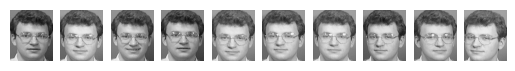

Class: s9


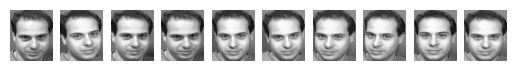

Class: s10


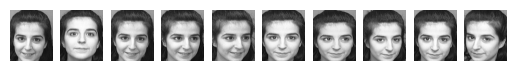

Class: s3


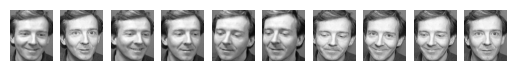

Class: s5


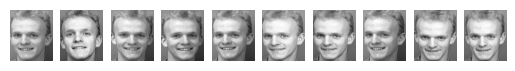

Class: s4


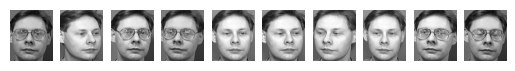

Class: s8


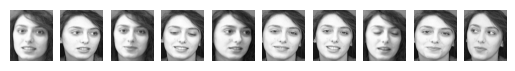

Class: s2


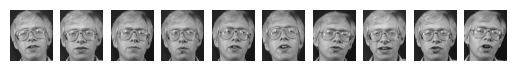

Class: s7


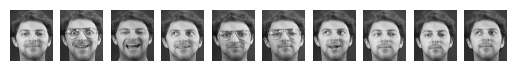

Class: s1


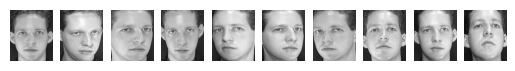

人脸 dict_keys(['s1/1.pgm', 's1/10.pgm', 's1/2.pgm', 's1/3.pgm', 's1/4.pgm', 's1/5.pgm', 's1/6.pgm', 's1/7.pgm', 's1/8.pgm', 's1/9.pgm', 's10/1.pgm', 's10/10.pgm', 's10/2.pgm', 's10/3.pgm', 's10/4.pgm', 's10/5.pgm', 's10/6.pgm', 's10/7.pgm', 's10/8.pgm', 's10/9.pgm', 's2/1.pgm', 's2/10.pgm', 's2/2.pgm', 's2/3.pgm', 's2/4.pgm', 's2/5.pgm', 's2/6.pgm', 's2/7.pgm', 's2/8.pgm', 's2/9.pgm', 's3/1.pgm', 's3/10.pgm', 's3/2.pgm', 's3/3.pgm', 's3/4.pgm', 's3/5.pgm', 's3/6.pgm', 's3/7.pgm', 's3/8.pgm', 's3/9.pgm', 's4/1.pgm', 's4/10.pgm', 's4/2.pgm', 's4/3.pgm', 's4/4.pgm', 's4/5.pgm', 's4/6.pgm', 's4/7.pgm', 's4/8.pgm', 's4/9.pgm', 's5/1.pgm', 's5/10.pgm', 's5/2.pgm', 's5/3.pgm', 's5/4.pgm', 's5/5.pgm', 's5/6.pgm', 's5/7.pgm', 's5/8.pgm', 's5/9.pgm', 's6/1.pgm', 's6/10.pgm', 's6/2.pgm', 's6/3.pgm', 's6/4.pgm', 's6/5.pgm', 's6/6.pgm', 's6/7.pgm', 's6/8.pgm', 's6/9.pgm', 's7/1.pgm', 's7/10.pgm', 's7/2.pgm', 's7/3.pgm', 's7/4.pgm', 's7/5.pgm', 's7/6.pgm', 's7/7.pgm', 's7/8.pgm', 's7/9.pgm', 's8/1.pg

In [5]:
# 从zip文件中读取人脸图像
faces, classes = read_faces_from_zip_or_folder("attface.zip")

# 按类别显示所有人脸图像
images_by_class_and_display(faces, classes)

# 打印一些细节
faceshape = list(faces.values())[0].shape
print("人脸", faces.keys())
print("人脸图像形状:", faceshape)
print("类别数量:", len(classes))
print("图像数量:", len(faces))
print("每个类别的图像数量:", {c: sum(1 for f in faces if f.startswith(c)) for c in classes})

In [6]:
# 为特征脸构建数据矩阵和标签向量
facematrix = []
facelabel = []
for key, val in faces.items():
    if key.startswith("s10/"):
        continue # 这是我们的测试集
    if key == "s1/10.pgm":
        continue # 这是我们的测试集
    if key == "s2/2.pgm":
        continue # 这是我们的测试集
    if key == "s3/6.pgm":
        continue # 这是我们的测试集
    if key == "s4/4.pgm":
        continue # 这是我们的测试集
    if key == "s5/7.pgm":
        continue # 这是我们的测试集
    if key == "s6/8.pgm":
        continue # 这是我们的测试集
    if key == "s7/3.pgm":
        continue # 这是我们的测试集
    if key == "s8/9.pgm":
        continue # 这是我们的测试集
    if key == "s9/1.pgm":
        continue # 这是我们的测试集
    facematrix.append(val.flatten())
    facelabel.append(key.split("\\")[0])

# 创建一个NxM矩阵，其中N为图像数量，M为每个图像的像素数
facematrix = np.array(facematrix)
print("训练集形状:", facematrix.shape)
print("训练集标签:", facelabel)

# 转置facematrix以匹配矩阵乘法的预期形状
facematrix_trans = facematrix.T

# 应用LPP并选择前K个主成分作为特征脸
n_components = 40
n_neighbors = 3600
t = 150000

# from lpproj import LocalityPreservingProjection
# eigenfaces = LPP(facematrix_trans, n_components, n_neighbors, t)
#lpp = LocalityPreservingProjection(n_neighbors=n_neighbors, n_components=n_components)
#lpp.fit(facematrix_trans)
#eigenfaces = lpp.transform(facematrix_trans)

eigenfaces = LPP(facematrix_trans, n_components, n_neighbors, t)
print("特征脸形状:", eigenfaces.shape)

mean_face = np.mean(facematrix_trans, axis=1)
print("平均人脸形状:", mean_face.shape)

weights = eigenfaces.T @ facematrix_trans
print("权重矩阵形状:", weights.shape)


训练集形状: (81, 10304)
训练集标签: ['s1/1.pgm', 's1/2.pgm', 's1/3.pgm', 's1/4.pgm', 's1/5.pgm', 's1/6.pgm', 's1/7.pgm', 's1/8.pgm', 's1/9.pgm', 's2/1.pgm', 's2/10.pgm', 's2/3.pgm', 's2/4.pgm', 's2/5.pgm', 's2/6.pgm', 's2/7.pgm', 's2/8.pgm', 's2/9.pgm', 's3/1.pgm', 's3/10.pgm', 's3/2.pgm', 's3/3.pgm', 's3/4.pgm', 's3/5.pgm', 's3/7.pgm', 's3/8.pgm', 's3/9.pgm', 's4/1.pgm', 's4/10.pgm', 's4/2.pgm', 's4/3.pgm', 's4/5.pgm', 's4/6.pgm', 's4/7.pgm', 's4/8.pgm', 's4/9.pgm', 's5/1.pgm', 's5/10.pgm', 's5/2.pgm', 's5/3.pgm', 's5/4.pgm', 's5/5.pgm', 's5/6.pgm', 's5/8.pgm', 's5/9.pgm', 's6/1.pgm', 's6/10.pgm', 's6/2.pgm', 's6/3.pgm', 's6/4.pgm', 's6/5.pgm', 's6/6.pgm', 's6/7.pgm', 's6/9.pgm', 's7/1.pgm', 's7/10.pgm', 's7/2.pgm', 's7/4.pgm', 's7/5.pgm', 's7/6.pgm', 's7/7.pgm', 's7/8.pgm', 's7/9.pgm', 's8/1.pgm', 's8/10.pgm', 's8/2.pgm', 's8/3.pgm', 's8/4.pgm', 's8/5.pgm', 's8/6.pgm', 's8/7.pgm', 's8/8.pgm', 's9/10.pgm', 's9/2.pgm', 's9/3.pgm', 's9/4.pgm', 's9/5.pgm', 's9/6.pgm', 's9/7.pgm', 's9/8.pgm', 's9/9

显示特征脸


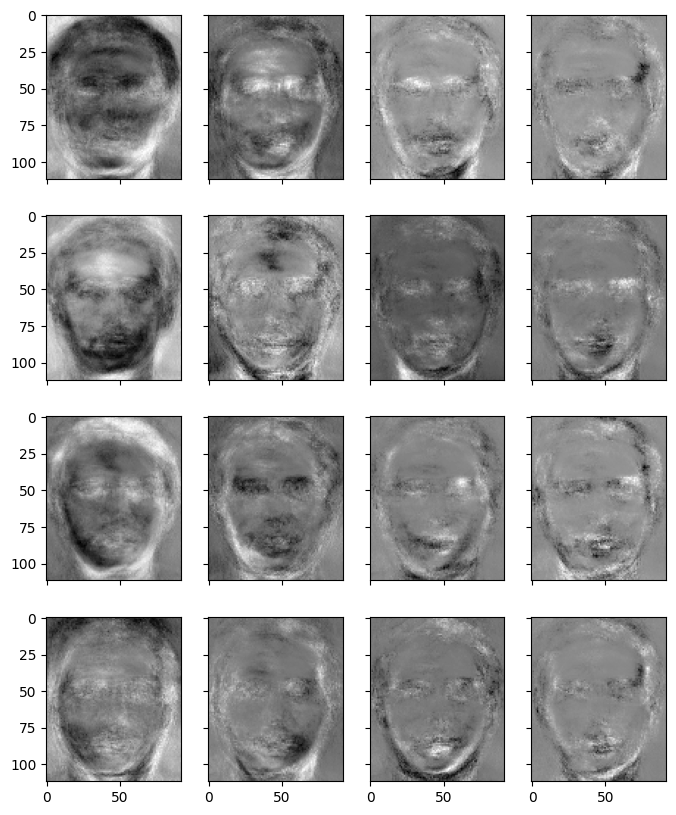

In [7]:
# 显示前16个特征脸
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 10))
for i in range(16):
    axes[i%4][i//4].imshow(eigenfaces[:, i].reshape(faceshape), cmap="gray")
print("显示特征脸")
plt.show()

In [8]:
def test_image(query, eigenfaces, mean_face, facelabel, weights):
    # 计算测试图像的权重向量
    query_weight = eigenfaces.T @ (query.flatten() - mean_face).reshape(-1, 1)
    print("测试图像的权重形状:", query_weight.shape)
    # 计算测试图像与数据集中每个人脸的欧氏距离
    euclidean_distances = np.linalg.norm(weights - query_weight, axis=0)
    # 找到最佳匹配的人脸
    best_match_index = np.argmin(euclidean_distances)
    print("最佳匹配 %s，欧几里得距离 %f" % (facelabel[best_match_index], euclidean_distances[best_match_index]))
    # 可视化
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 6))
    axes[0].imshow(query.reshape(faceshape), cmap="gray")
    axes[0].set_title("Query Image")
    axes[1].imshow(facematrix[best_match_index].reshape(faceshape), cmap="gray")
    axes[1].set_title("Best Match")
    plt.show()
    return best_match_index, euclidean_distances[best_match_index]


测试图像的权重形状: (40, 1)
最佳匹配 s5/10.pgm，欧几里得距离 1603.829263


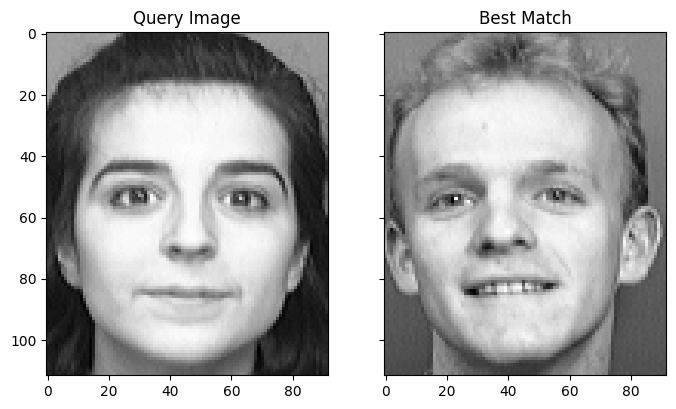

测试图像的权重形状: (40, 1)
最佳匹配 s1/5.pgm，欧几里得距离 2442.326774


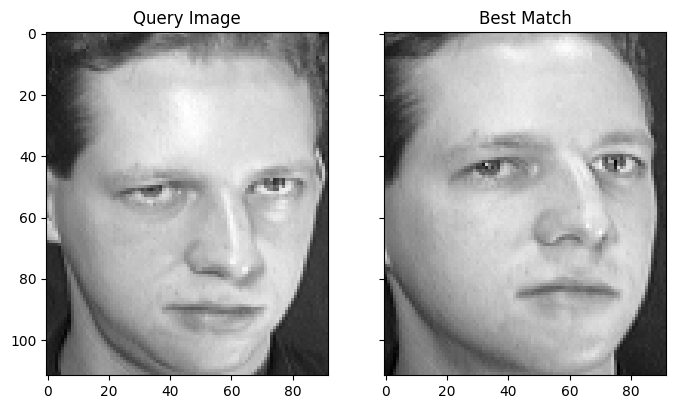

测试图像的权重形状: (40, 1)
最佳匹配 s1/2.pgm，欧几里得距离 2040.514764


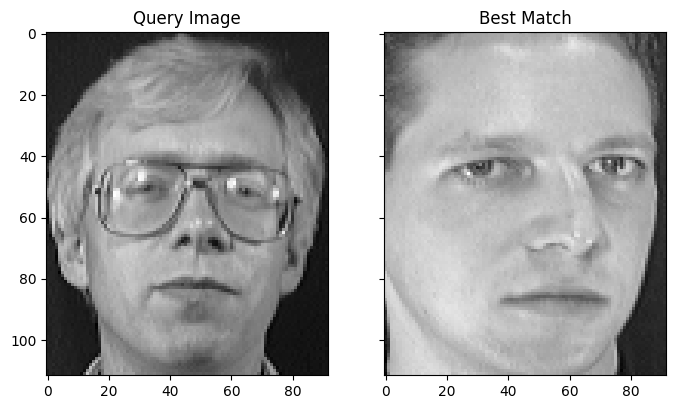

测试图像的权重形状: (40, 1)
最佳匹配 s3/2.pgm，欧几里得距离 2061.317241


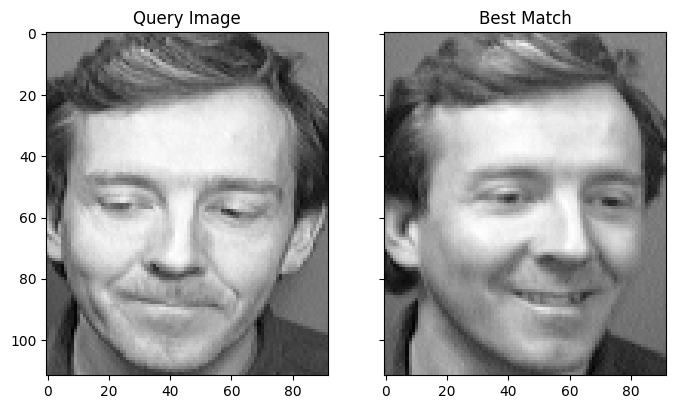

测试图像的权重形状: (40, 1)
最佳匹配 s4/9.pgm，欧几里得距离 2518.406742


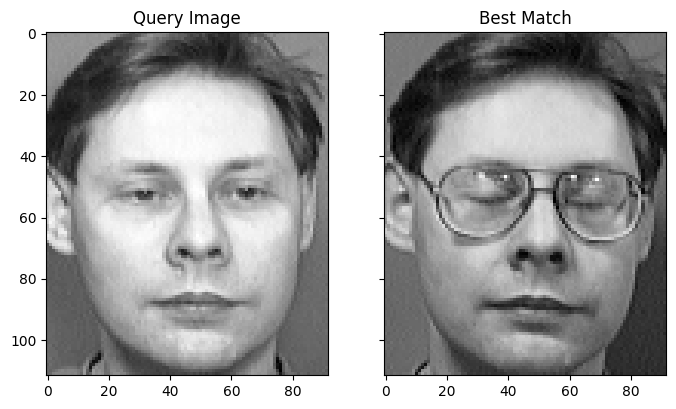

测试图像的权重形状: (40, 1)
最佳匹配 s5/4.pgm，欧几里得距离 2808.446844


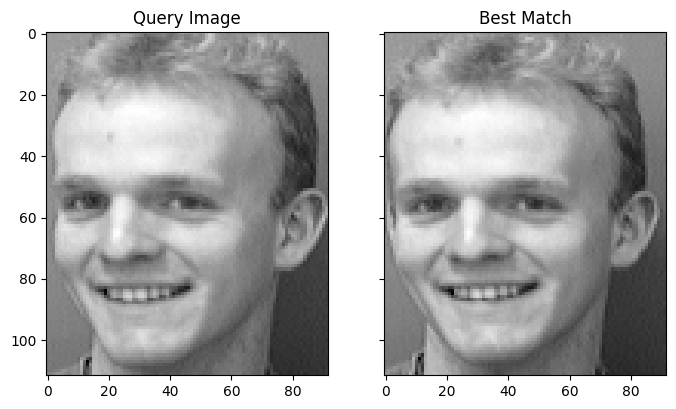

测试图像的权重形状: (40, 1)
最佳匹配 s6/4.pgm，欧几里得距离 3027.454953


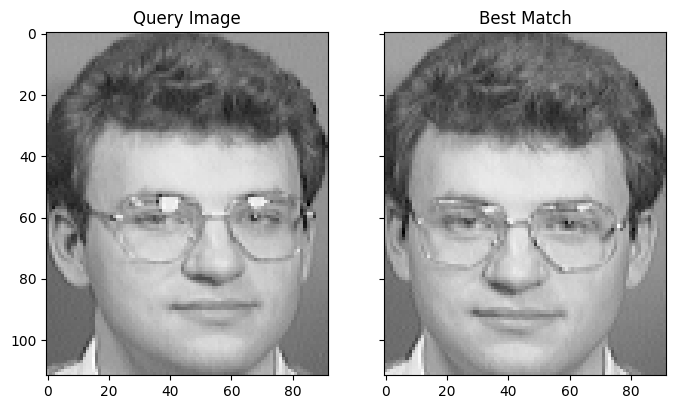

测试图像的权重形状: (40, 1)
最佳匹配 s7/4.pgm，欧几里得距离 2188.498205


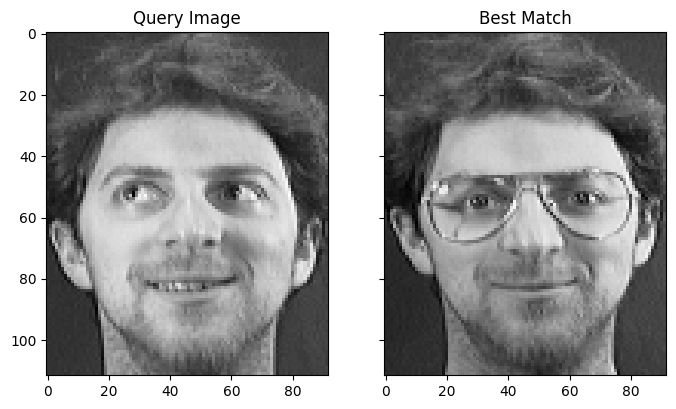

测试图像的权重形状: (40, 1)
最佳匹配 s5/10.pgm，欧几里得距离 1770.473063


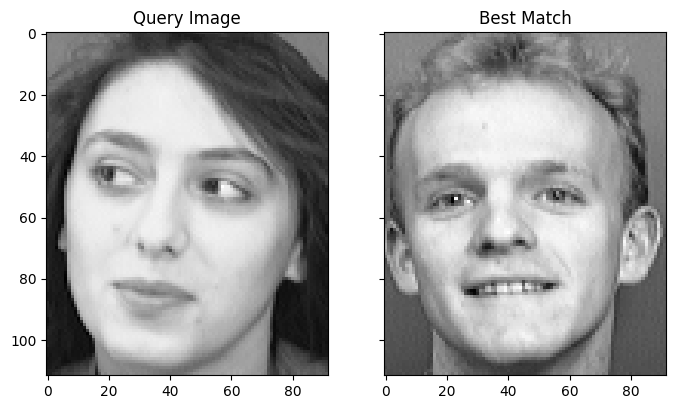

测试图像的权重形状: (40, 1)
最佳匹配 s6/1.pgm，欧几里得距离 2481.256018


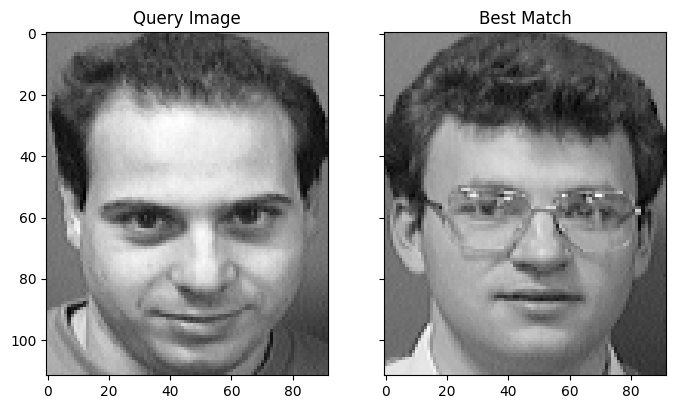

(45, 2481.256017998178)

In [9]:
# 测试图像
test_image(faces["s10/10.pgm"], eigenfaces, mean_face, facelabel, weights)
test_image(faces["s1/10.pgm"], eigenfaces, mean_face, facelabel, weights)
test_image(faces["s2/2.pgm"], eigenfaces, mean_face, facelabel, weights)
test_image(faces["s3/6.pgm"], eigenfaces, mean_face, facelabel, weights)
test_image(faces["s4/4.pgm"], eigenfaces, mean_face, facelabel, weights)
test_image(faces["s5/7.pgm"], eigenfaces, mean_face, facelabel, weights)
test_image(faces["s6/8.pgm"], eigenfaces, mean_face, facelabel, weights)
test_image(faces["s7/3.pgm"], eigenfaces, mean_face, facelabel, weights)
test_image(faces["s8/9.pgm"], eigenfaces, mean_face, facelabel, weights)
test_image(faces["s9/1.pgm"], eigenfaces, mean_face, facelabel, weights)